# Лабораторная работа №2

Выполнил Гиголаев Антон М8О-309Б-22

Задания: 
1) Написать класс, реализующий свой линейный классификатор и логистическую регрессию с методами fit и predict.

2) Решить задачу с помощью готовых реализаций:
— Логистическая регрессия: sklearn
— SVM: sklearn
— Решающее дерево: sklearn
— Случайный лес: sklearn
— Градиентный бустинг: sklearn, LightGBM, XGBoost, catboost
На доп. балл: использование других реализаций методов.
На доп. балл: использование одного любого другого метода машинного обучения, не включая нейросети, для решения данной задачи.

3) Посчитать метрики precision, recall, F1-меру, accuracy для всех решений, визуализировать confusion matrix (с помощью matplotlib/seaborn/любая другая библиотека для визуализации) также для всех решений. 

4) Сделать выводы, минимум 7-10 предложений. Также не забудьте сказать, какая метрика была наиболее информативной в этой задаче.

In [111]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



## Загрузка данных

In [112]:
import pandas as pd

file_path = 'train.csv'
data = pd.read_csv(file_path)

data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

(None,
   ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
 0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
 1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
 2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
 3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
 4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   
 
   MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
 0      Divorced                 1.0                Rent               1095.0   
 1       Widowed                 1.0            Mortgage                211.0   
 2       Married                 0.0            Mortgage                546.0   
 3       Married                 0.0               Other                153.0   
 4        Single                 2.0                Rent                562.0   
 
    ...  Employme

## Препроцессинг

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

critical_columns = ['LoanApproved', 'CreditScore', 'LoanAmount', 'MonthlyDebtPayments', 'NetWorth']
data_cleaned = data.dropna(subset=critical_columns)

for column in data_cleaned.columns:
    if data_cleaned[column].dtype == 'object':
        data_cleaned[column] = data_cleaned[column].fillna(data_cleaned[column].mode()[0])
    else:
        data_cleaned[column] = data_cleaned[column].fillna(data_cleaned[column].mean())

categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns.difference(['LoanApproved'])
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

X = data_cleaned.drop(columns=['LoanApproved'])
y = data_cleaned['LoanApproved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


C:\Users\zerotonyq\AppData\Local\Temp\ipykernel_4804\3559602155.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].fillna(data_cleaned[column].mode()[0])
C:\Users\zerotonyq\AppData\Local\Temp\ipykernel_4804\3559602155.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].fillna(data_cleaned[column].mean())
C:\Users\zerotonyq\AppData\Local\Temp\ipykernel_4804\3559602155.py:18: SettingWithCopyWarning: 
A value is trying t

((7988, 35), (1998, 35), (7988,), (1998,))

## Кастомный линейный классификатор (логистическая регрессия с сигмоидой)

In [114]:
import numpy as np

class CustomLinearClassifier:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.where(y_predicted >= 0.5, 1, 0)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [115]:
custom_model = CustomLinearClassifier(learning_rate=0.01, n_iterations=1000)
custom_model.fit(X_train.values, y_train.values)

custom_predictions = custom_model.predict(X_test.values)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

custom_metrics = {
    "precision": precision_score(y_test, custom_predictions),
    "recall": recall_score(y_test, custom_predictions),
    "f1_score": f1_score(y_test, custom_predictions),
    "accuracy": accuracy_score(y_test, custom_predictions),
    "confusion_matrix": confusion_matrix(y_test, custom_predictions),
}

custom_metrics


{'precision': 0.9351669941060904,
 'recall': 0.9206963249516441,
 'f1_score': 0.9278752436647173,
 'accuracy': 0.9259259259259259,
 'confusion_matrix': array([[898,  66],
        [ 82, 952]])}

Кастомная логистическая регрессия дала следующие результаты:

Precision: 93.52%
Recall: 92.07%
F1-Score: 92.79%
Accuracy: 92.59%
Confusion Matrix: [[898,  66], [ 82, 952]]

### Готовая логистическая регрессия

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

logistic_metrics = {
    "precision": precision_score(y_test, logistic_predictions),
    "recall": recall_score(y_test, logistic_predictions),
    "f1_score": f1_score(y_test, logistic_predictions),
    "accuracy": accuracy_score(y_test, logistic_predictions),
    "confusion_matrix": confusion_matrix(y_test, logistic_predictions),
}


### SVM

In [117]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

svm_metrics = {
    "precision": precision_score(y_test, svm_predictions),
    "recall": recall_score(y_test, svm_predictions),
    "f1_score": f1_score(y_test, svm_predictions),
    "accuracy": accuracy_score(y_test, svm_predictions),
    "confusion_matrix": confusion_matrix(y_test, svm_predictions),
}



### Решающее дерево

In [118]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_predictions = tree_model.predict(X_test)

tree_metrics = {
    "precision": precision_score(y_test, tree_predictions),
    "recall": recall_score(y_test, tree_predictions),
    "f1_score": f1_score(y_test, tree_predictions),
    "accuracy": accuracy_score(y_test, tree_predictions),
    "confusion_matrix": confusion_matrix(y_test, tree_predictions),
}


### Случайный лес

In [119]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state=42)
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)

forest_metrics = {
    "precision": precision_score(y_test, forest_predictions),
    "recall": recall_score(y_test, forest_predictions),
    "f1_score": f1_score(y_test, forest_predictions),
    "accuracy": accuracy_score(y_test, forest_predictions),
    "confusion_matrix": confusion_matrix(y_test, forest_predictions),
}



### Градиентный бустинг

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

gb_metrics = {
    "precision": precision_score(y_test, gb_predictions),
    "recall": recall_score(y_test, gb_predictions),
    "f1_score": f1_score(y_test, gb_predictions),
    "accuracy": accuracy_score(y_test, gb_predictions),
    "confusion_matrix": confusion_matrix(y_test, gb_predictions),
}



# Визуализация

### Логистическая регрессия(готовая)

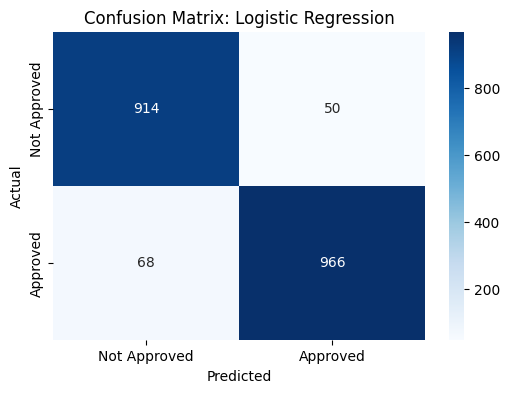

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(logistic_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### SVM

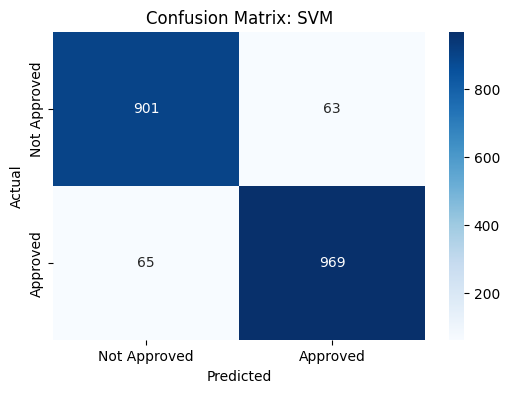

In [122]:
plt.figure(figsize=(6, 4))
sns.heatmap(svm_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title("Confusion Matrix: SVM")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Решающее дерево

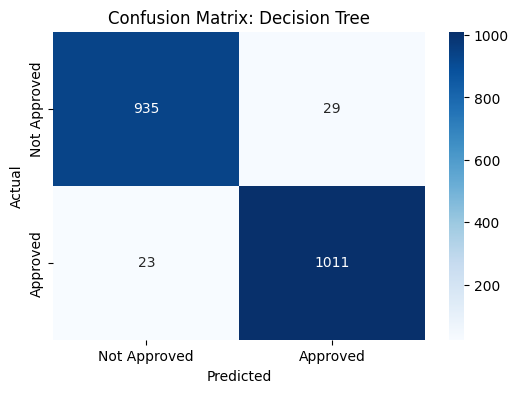

In [123]:
plt.figure(figsize=(6, 4))
sns.heatmap(tree_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title("Confusion Matrix: Decision Tree")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Случайный лес

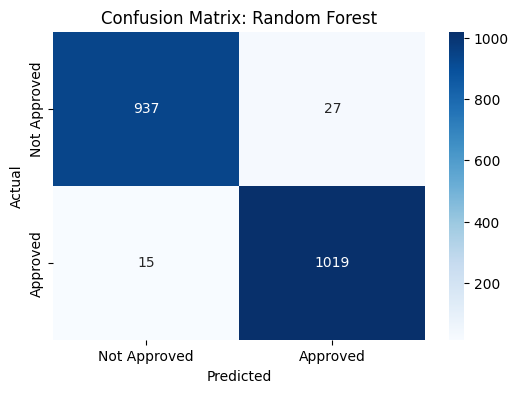

In [124]:
plt.figure(figsize=(6, 4))
sns.heatmap(forest_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title("Confusion Matrix: Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Градиентный бустинг

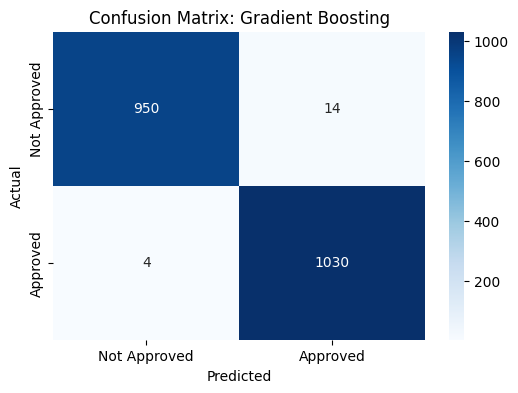

In [125]:
plt.figure(figsize=(6, 4))
sns.heatmap(gb_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title("Confusion Matrix: Gradient Boosting")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
